# Old or not
**Student**: Tristan Gerritsen \
**Nummer:** S1158446 \
**AI-gebruik:** geen

## 1. Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

## 2. Data Understanding: 

Eerst importeren we de packages:

In [36]:
#importeer de juiste packages
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

import os
import cv2
import math
import pickle
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns

Nu definieer ik wat constantes zodat ze duidelijk zijn, en als ik later wat wil tweaken kan dat makkelijk hier.

In [2]:
# Constantes
DF_FILTERED_NAME = "cache_df_filtered.feather"  # https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON = 50000
OLDNESS_THRESHOLD = 42
VARIATION_RANGE = 0.1

# afbeeldingen
WIDTH = HEIGHT = 100
SIZE = (WIDTH, HEIGHT)

Lees de metadata in. Deze is in een obscuur MATLAB-formaat, maar gelukkig heeft `scipy.io` hier een handige tool voor. De optie `squeeze_me` maakt de datastructuur zo plat mogelijk, anders moet je telkens werken met arrays van 1 element.

In [3]:
mat: dict = loadmat("imdb_crop/imdb.mat", squeeze_me=True)

Nu check ik even wat er te vinden is in deze structuur, en ik heb deze vergeleken met wat er op de website staat.

In [4]:
print("Keys in de metadata:", mat.keys())

imdb: np.ndarray = mat["imdb"]

print("Keys in de imdb array:", imdb.dtype)

Keys in de metadata: dict_keys(['__header__', '__version__', '__globals__', 'imdb'])
Keys in de imdb array: [('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


Nu pak ik de IMBD-array-sleutels even uit: 

In [5]:
(dob, photo_taken, full_path, gender, name, face_location, face_score, second_face_score, celeb_names, celeb_id) = imdb.tolist()

Om iets te kunnen doen met de data, check ik even in wat voor formaat het is:

In [6]:
print(f"Eerste persoon is: {name[0]}")
print(f"Eerste geboortedatum: {dob[0]} van het type {type(dob[0])}")
print(f"Eerste fotodatum: {photo_taken[0]} van het type {type(photo_taken[0])}")

Eerste persoon is: Fred Astaire
Eerste geboortedatum: 693726 van het type <class 'numpy.int32'>
Eerste fotodatum: 1968 van het type <class 'numpy.uint16'>


Hmm, een `numpy.int32` datum zegt mij niet zoveel. Het lijkt ook niet op een UNIX timestamp, want die gaan per seconden, en [Fred Astaire](https://nl.wikipedia.org/wiki/Fred_Astaire), is geboren op 10 mei 1899, terwijl de UNIX-timestamp dan zou zeggen Fri Jan 09 00:42:06 1970.

Als we kijken op de [MATLAB-referentiesite](https://nl.mathworks.com/help/matlab/ref/datetime.datenum.html), zien we de uitleg van dit datatype:
> A serial date number represents the whole and fractional number of days from a fixed, preset date (January 0, 0000) in the proleptic ISO calendar.

Om dit om te zetten naar het een datum waar ik iets aan heb, moet ik ervoor zorgen dat de datum die [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) verwacht (de UNIX-epoch van 1970), overeenkomt met wat wij meegeven. Omdat er een hoop schrikkeldagen zijn geweest in de geschiedenis, gebruik ik de code van dit artikel: <http://sociograph.blogspot.com/2011/04/how-to-avoid-gotcha-when-converting.html>

In [7]:
def convertDate(date):
    EPOCH = 719529
    return pd.to_datetime(int(date) - EPOCH, unit='D')

print("Geconverteerde geboortedatum is:", convertDate(dob[0]))

Geconverteerde geboortedatum is: 1899-05-10 00:00:00


Conversie-functie lijkt te werken, want als ik op [de Wikipedia-pagina van Fred Astaire](https://nl.wikipedia.org/wiki/Fred_Astaire) kijk, dan klopt de geboortedatum van 10 mei 1899.

### 2.x. Afbeeldingen

Foto van Simon Helberg
  Shape (w, h, c): (87, 87, 3)
Foto van Robin Williams
  Shape (w, h, c): (175, 175, 3)
Foto van Jim Carrey
  Shape (w, h, c): (500, 500, 3)
Foto van Meredith Scott Lynn
  Shape (w, h, c): (132, 133, 3)
Foto van Steve McQueen
  Shape (w, h, c): (284, 284, 3)


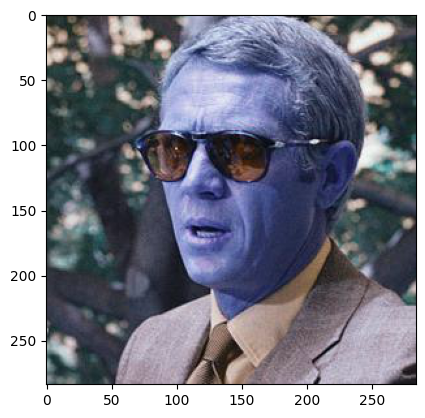

In [8]:
for idx in random.sample(range(0, len(full_path)), 5):
    print(f"Foto van {name[idx]}")

    img = cv2.imread(f"imdb_crop/{full_path[idx]}")

    width = img.shape[0]
    height = img.shape[0]
    print(f"  Shape (w, h, c): {img.shape}")

    plt.imshow(img)

Hieruit kunnen we zien dat de afbeeldingen verschillende grootten hebben, en dat de afbeelding in een BGR-formaat ingeladen is. De blauwigheid hiervan moeten we er nog uithalen.

## 3. Data preparation: 

### 3.1. Leeftijdsbepaling
Bepaal op basis van de metadata hoe oud de personen op de foto's waren toen deze genomen werden (`-1` als onbekend)

In [9]:
def tryCalculateAge(date_of_birth: np.int32, year_foto_taken: np.uint16):
    try:
        date_of_birth: pd.Timestamp = convertDate(date_of_birth)
        return year_foto_taken - date_of_birth.year
    except Exception as e:
        return -1


if os.path.exists("training_1/age_cache.pkl"):
    with open("training_1/age_cache.pkl", "rb") as f:
        age_on_photo = pickle.load(f)
else:
    age_on_photo = [tryCalculateAge(dob[i], photo_taken[i]) for i in range(0, len(dob))]
    with open("training_1/age_cache.pkl", "wb") as f:
        pickle.dump(age_on_photo, f)

### 3.2. Dataset maken
Voeg de ingelezen metadata en de berekende leeftijd samen tot een nieuwe dataset:

In [10]:
df = pd.DataFrame(data={
    'name': name,
    'full_path': full_path,
    'age_on_photo': age_on_photo,
    'face_score': face_score,
    'second_face_score': second_face_score,
    'gender': gender,
    'face_score': face_score,
    'face_location': face_location
})
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               460723 non-null  object 
 1   full_path          460723 non-null  object 
 2   age_on_photo       460723 non-null  int64  
 3   face_score         460723 non-null  float64
 4   second_face_score  213797 non-null  float64
 5   gender             452261 non-null  float64
 6   face_location      460723 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 24.6+ MB


,name,full_path,age_on_photo,face_score,second_face_score,gender,face_location
0,Fred Astaire,01/nm0000001_rm124825600_1899-5-10_1968.jpg,69,1.459693,1.118973,1.0,"[1072.926, 161.838, 1214.7839999999999, 303.69..."
1,Fred Astaire,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,71,2.543198,1.852008,1.0,"[477.184, 100.352, 622.592, 245.76]"
2,Fred Astaire,01/nm0000001_rm577153792_1899-5-10_1968.jpg,69,3.455579,2.985660,1.0,"[114.96964308962852, 114.96964308962852, 451.6..."
3,Fred Astaire,01/nm0000001_rm946909184_1899-5-10_1968.jpg,69,1.872117,NaN,1.0,"[622.8855056426588, 424.21750383700805, 844.33..."
4,Fred Astaire,01/nm0000001_rm980463616_1899-5-10_1968.jpg,69,1.158766,NaN,1.0,"[1013.8590023603723, 233.8820422075853, 1201.5..."


### 3.3. Opschonen
schoon de dataset op op basis van de bij de business understanding gegeven criteria.

#### 3.3.1 Zorg dat er alleen mensen zijn van minstens 21 jaar oud

In [11]:
df_filtered = df[df['age_on_photo'] >= 21]
print(f"Er zijn nog {len(df_filtered)} rijen over")

Er zijn nog 424839 rijen over


#### 3.3.2. Zorg dat er alleen foto’s zijn waar gezichten op gevonden zijn
> **face_score:** detector score (the higher the better). \
> Inf implies that no face was found in the image and the face_location then just returns the entire image

In [12]:
df_filtered = df_filtered[df_filtered['face_score'] != np.Infinity]
df_filtered = df_filtered[df_filtered['face_score'] != -np.Infinity]
print(f"Er zijn nog {len(df_filtered)} rijen over")

Er zijn nog 368386 rijen over


#### 3.3.3. Zorg dat er alleen foto’s zijn waar maar één gezicht op staat
> **second_face_score:** detector score of the face with the second highest score. \
> This is useful to ignore images with more than one face. \
> second_face_score is NaN if no second face was detected.


In [13]:
df_filtered = df_filtered[pd.isna(df_filtered['second_face_score'])]
print(f"Er zijn nog {len(df_filtered)} rijen over")

Er zijn nog 170935 rijen over


#### 3.3.4. Bereken de ‘oudheid’ van de mensen in de foto’s
Omdat we hier daadwerkelijk mee gaan werken, zorg ik dat deze netjes in de dataframe staat.

In [14]:
df_filtered['oldness'] = df_filtered.apply(lambda row: int(row.age_on_photo >= OLDNESS_THRESHOLD), axis=1)

#### 3.3.5. Gebruik een subset van de dataset
Hiermee voorkom ik dat mijn computer in de fik vliegt.

In [15]:
df_filtered = df_filtered.head(COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON)

#### 3.3.4. Evaluatie van de filtering

In [16]:
print(f"Gemiddelde oudheid: {df_filtered['oldness'].mean()}")

df_filtered.info()
df_filtered.head()

Gemiddelde oudheid: 0.55768
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 3 to 125817
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50000 non-null  object 
 1   full_path          50000 non-null  object 
 2   age_on_photo       50000 non-null  int64  
 3   face_score         50000 non-null  float64
 4   second_face_score  0 non-null      float64
 5   gender             49859 non-null  float64
 6   face_location      50000 non-null  object 
 7   oldness            50000 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.4+ MB


,name,full_path,age_on_photo,face_score,second_face_score,gender,face_location,oldness
3,Fred Astaire,01/nm0000001_rm946909184_1899-5-10_1968.jpg,69,1.872117,NaN,1.0,"[622.8855056426588, 424.21750383700805, 844.33...",1
4,Fred Astaire,01/nm0000001_rm980463616_1899-5-10_1968.jpg,69,1.158766,NaN,1.0,"[1013.8590023603723, 233.8820422075853, 1201.5...",1
6,Lauren Bacall,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,80,3.479189,NaN,0.0,"[78.23569406558903, 52.335129377059346, 194.25...",1
7,Lauren Bacall,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,80,3.870171,NaN,0.0,"[64.30867103752385, 64.30867103752385, 207.267...",1
12,Lauren Bacall,02/nm0000002_rm221957120_1924-9-16_1974.jpg,50,4.096431,NaN,0.0,"[3173.144692593433, 401.0408365741791, 4059.15...",1


Ook zorg ik ervoor dat de data netjes is opgeslagen, zodat ik er later mee kan werken inhoeverre nodig.

In [17]:
df_filtered.to_feather(DF_FILTERED_NAME)

### 3.4. Afbeeldingen inlezen
Om wat performance te besparen voor laptopje, doe ik een aantal stappen in een keer, en gebruik de cv2-bibliotheek voor performance ([bron](https://towardsdatascience.com/image-processing-opencv-vs-pil-a26e9923cdf3)).

#### 3.4.1. Caching
Ik gebruik hier de hevigste caching, op mijn MacBook M1 Pro duurt een cold run $90+$ seconden, maar een hot (gecachete) maar ongeveer $\pm 10$ seconden.

In [21]:
def implReadImage(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Bestand {path} bestaat niet")

    # Cache de image-conversion, het duurt anders echt heel lang
    cachePath = path.replace("jpg", "cached.jpg")
    if os.path.exists(cachePath):
        return cv2.imread(cachePath)

    img = cv2.imread(path)

    # Afbeelding is in BGR formaat, maar plt wil RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Voorkom dat we werken met verschillende grootte afbeeldingen; tensorflow vindt dat niet leuk
    img = cv2.resize(img, SIZE)

    # Schrijf de geoptimaliseerde image naar een cache
    cv2.imwrite(cachePath, img)
    return img

def readImage(path: str):
    img = implReadImage(path)
    # Normalisatie
    return np.divide(img, 255.0)

images = np.zeros((len(df_filtered), WIDTH, HEIGHT, 3))
for idx, path in enumerate(df_filtered['full_path']):
    images[idx] = readImage("imdb_crop/" + path)

#### 3.4.2. Validatie van de ingelezen afbeeldingen
Ik plot de eerste 25 afbeeldingen om te kijken of alles goed is gegaan.

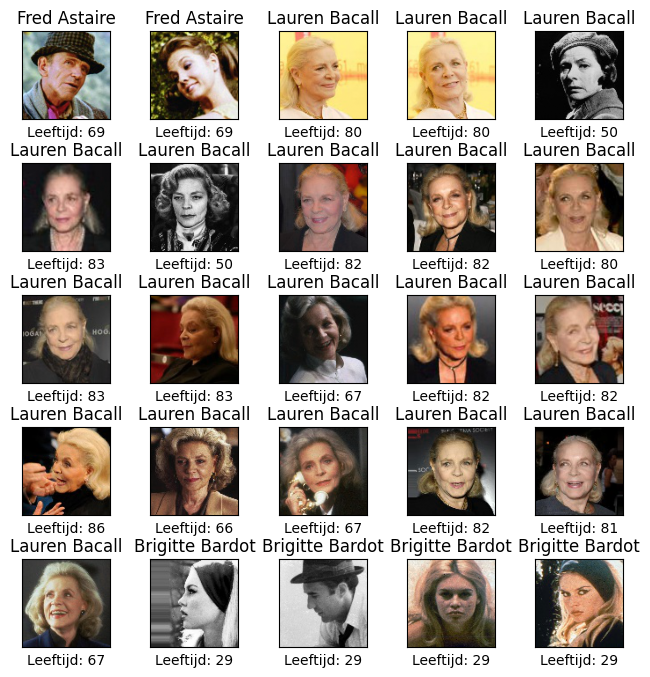

In [22]:
fig = plt.figure(figsize=(8, 8))

# Zorg dat we genoeg ruimte hebben tussen de afbeeldingen voor de naam (titel) en leeftijd (xlabel)
fig.subplots_adjust(hspace=0.5)

for i in range(25):
    plt.subplot(5, 5, i + 1)

    plt.title(df_filtered.iloc[i]["name"])
    plt.xlabel(f'Leeftijd: {df_filtered.iloc[i]["age_on_photo"]}')

    plt.xticks([])
    plt.yticks([])

    plt.imshow(images[i])
plt.show()

## 4. Modeling

In [23]:
ages = np.array(df_filtered['oldness'])
print("Oudheid:", ages.shape)

age_on_photos = np.array(df_filtered['age_on_photo'])
print("AgeOnPhotos:", ages.shape)

names = np.array(df_filtered['name'])
print("Namen:", names.shape)

print("Afbeeldingen:", images.shape)

Oudheid: (50000,)
AgeOnPhotos: (50000,)
Namen: (50000,)
Afbeeldingen: (50000, 100, 100, 3)


#### 4.1. Dataset splitsen tussen train- en testdata
Omdat 20% van de data als testset gebruikt moet worden, gebruik ik de [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) van sklearn.

In [24]:
indices = np.arange(0, COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON)
train_images, test_images, train_ages, test_ages, train_indices, test_indices  = train_test_split(images, ages, indices, test_size=0.2, random_state=42)

In [29]:
del images
del df
del mat
del imdb

#### 4.2. Check of het allemaal nog werkt
Om te checken of de `train_test_split`-functie op de juiste manier gebruikt wordt, plot ik de verdeling van de leeftijden in de trainset samen met de `oudheid`.

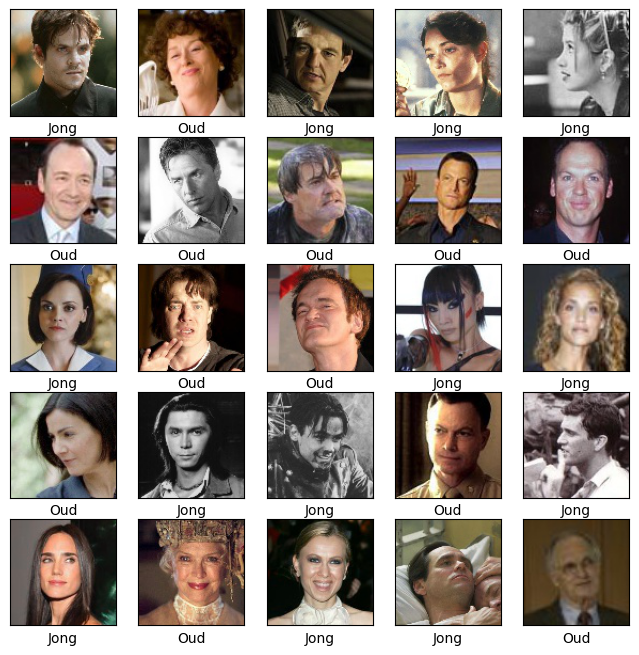

In [25]:
plt.figure(figsize=(8,8))
for i in range(min(25, len(train_images))):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
     #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.imshow(images[train_indices[i]])
    plt.xlabel("Oud" if train_ages.tolist()[i] == 1 else "Jong")
plt.show()

#### 4.3. Variatie maken op de trainingsdata
Maak wat verschil in de invoerdata om het model beter te maken dan de voorgedefinieerde traindata. Ook interessant is de `horizontal_flip`-optie, want op sommige foto’s kijken mensen naar links of rechts, en ik wil voorkomen dat het model daar een bias in maakt.

In [26]:
train_datagen = ImageDataGenerator(
    width_shift_range=VARIATION_RANGE,
    height_shift_range=VARIATION_RANGE,
    shear_range=VARIATION_RANGE,
    zoom_range=VARIATION_RANGE,
    horizontal_flip=True,
)
data_flow = train_datagen.flow(train_images, tf.reshape(train_ages, (-1)), shuffle=True)

2024-09-22 23:01:38.039667: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-22 23:01:38.040161: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-22 23:01:38.040167: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-22 23:01:38.040501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-22 23:01:38.040527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 4.4. Model opzetten

Ik zag dat de 'ADAM' optimizer niet geschikt was, omdat de learning rates afnemend waren, dus ik koos voor de RMSprop-optimizer.

In [37]:
model = models.Sequential([
    layers.Input(shape=(WIDTH, HEIGHT, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding="SAME"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", "Precision", "Recall"])

#### 4.5. Checkpoints en backup
Door [checkpoints te gebruiken](https://www.tensorflow.org/guide/checkpoint), kan ik het werk zo weer oppakken als er iets misgaat, zoals het crashen van de Jupyter-kernel.

In [39]:
model_path = os.path.abspath("training_1/model.keras")
checkpoint_path = os.path.abspath("training_1/cp.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

print(f"We gaan checkpoints opslaan in {pathlib.Path(checkpoint_path).as_uri()}")
print(f"Overeenkomstig de map: {checkpoint_dir}")

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

batch_size = 64

n_batches = math.ceil(len(train_images) / batch_size)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=n_batches,
                                                 verbose=1)

We gaan checkpoints opslaan in file:///Users/tager/Developer/School/MachineLearning/Thema%202/training_1/cp.weights.h5
Overeenkomstig de map: /Users/tager/Developer/School/MachineLearning/Thema 2/training_1


#### 4.6. Weights backup

In [40]:
if os.path.exists(checkpoint_path):
    latest_weights = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_weights is not None:
        model.load_weights(latest_weights)
        print("De laatste gewichten zijn geladen")

In [42]:
(loss, acc, precision, recall) = model.evaluate(test_images, test_ages, verbose=2)
print("Huidige accuracy van het model is: {:5.2f}%, precision={:5.2f}% en recall={:5.2f}%".format(100 * acc, 100 * precision, 100 * recall))

KeyboardInterrupt: 

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        15,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,633 (428.25 KB)

 Trainable params: 109,185 (426.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [44]:
history = model.fit(data_flow,
                    epochs=50,
                    validation_data=(test_images, test_ages),
                    batch_size=batch_size,
                    callbacks=[cp_callback])

Epoch 1/50
 624/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - Precision: 0.5979 - Recall: 0.6250 - accuracy: 0.5604 - loss: 0.8616
Epoch 1: saving model to /Users/tager/Developer/School/MachineLearning/Thema 2/training_1/cp.weights.h5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - Precision: 0.6043 - Recall: 0.6352 - accuracy: 0.5655 - loss: 0.8352
Epoch 1: saving model to /Users/tager/Developer/School/MachineLearning/Thema 2/training_1/cp.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - Precision: 0.6043 - Recall: 0.6352 - accuracy: 0.5655 - loss: 0.8351 - val_Precision: 0.6247 - val_Recall: 0.6816 - val_accuracy: 0.6002 - val_loss: 0.7432
Epoch 2/50
 624/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - Precision: 0.6167 - Recall: 0.6550 - accuracy: 0.5776 - loss: 0.7444
Epoch 2: saving model to /Users/tager/Developer/School/MachineLearning/Thema 2/training_1/cp.weights.h5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - Precision: 0.6210 - Recall: 0.6624 - accuracy: 0.5831 - loss: 0.7386
E

Sla het model op, zodat als er iets gebeurt, ik het nog kan raadplegen.

In [45]:
model.save(filepath=model_path)

## 5. Evaluation
In dit hoofdstuk check ik hoe goed het model het doet.

In [46]:
(loss, acc, precision, recall) = model.evaluate(test_images, test_ages, verbose=2)
print("Accuracy van het model is na het trainen: {:5.2f}%, precision={:5.2f}% en recall={:5.2f}%".format(100 * acc, 100 * precision, 100 * recall))

313/313 - 6s - 19ms/step - Precision: 0.6378 - Recall: 0.8784 - accuracy: 0.6592 - loss: 0.7017
Accuracy van het model is na het trainen: 65.92%, precision=63.78% en recall=87.84%


#### 5.1. Validated accuracy

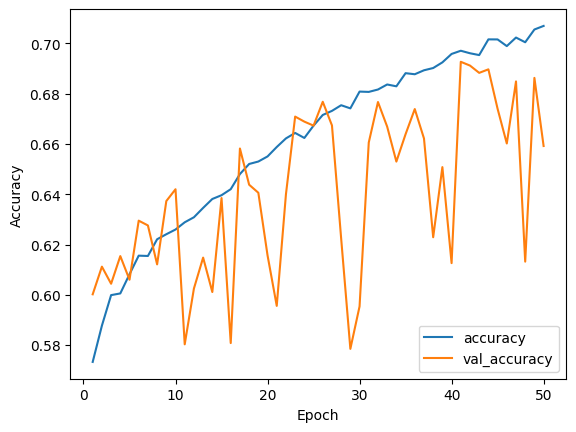

In [47]:
#plot de accuracy en validated accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#### 5.2. Heatmap van de confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


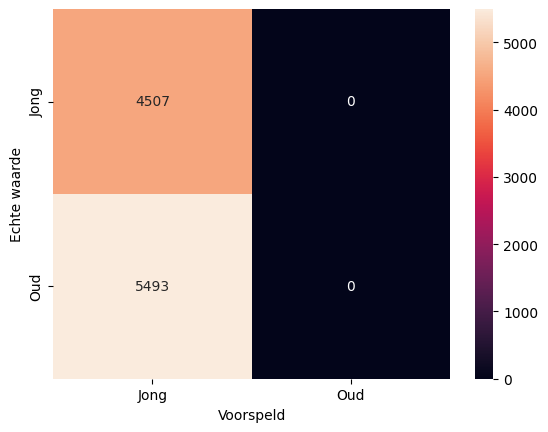

In [48]:
predict = model.predict(test_images)
Y_predict = np.argmax(predict, axis=1)
cm = confusion_matrix(test_ages, Y_predict)

s = sns.heatmap(cm,
                annot=True,
                fmt='d',
                xticklabels=["Jong", "Oud"],
                yticklabels=["Jong", "Oud"],
)
s.set(xlabel='Voorspeld', ylabel='Echte waarde');

#### 5.3. Evaluatie jegens IMDB-data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


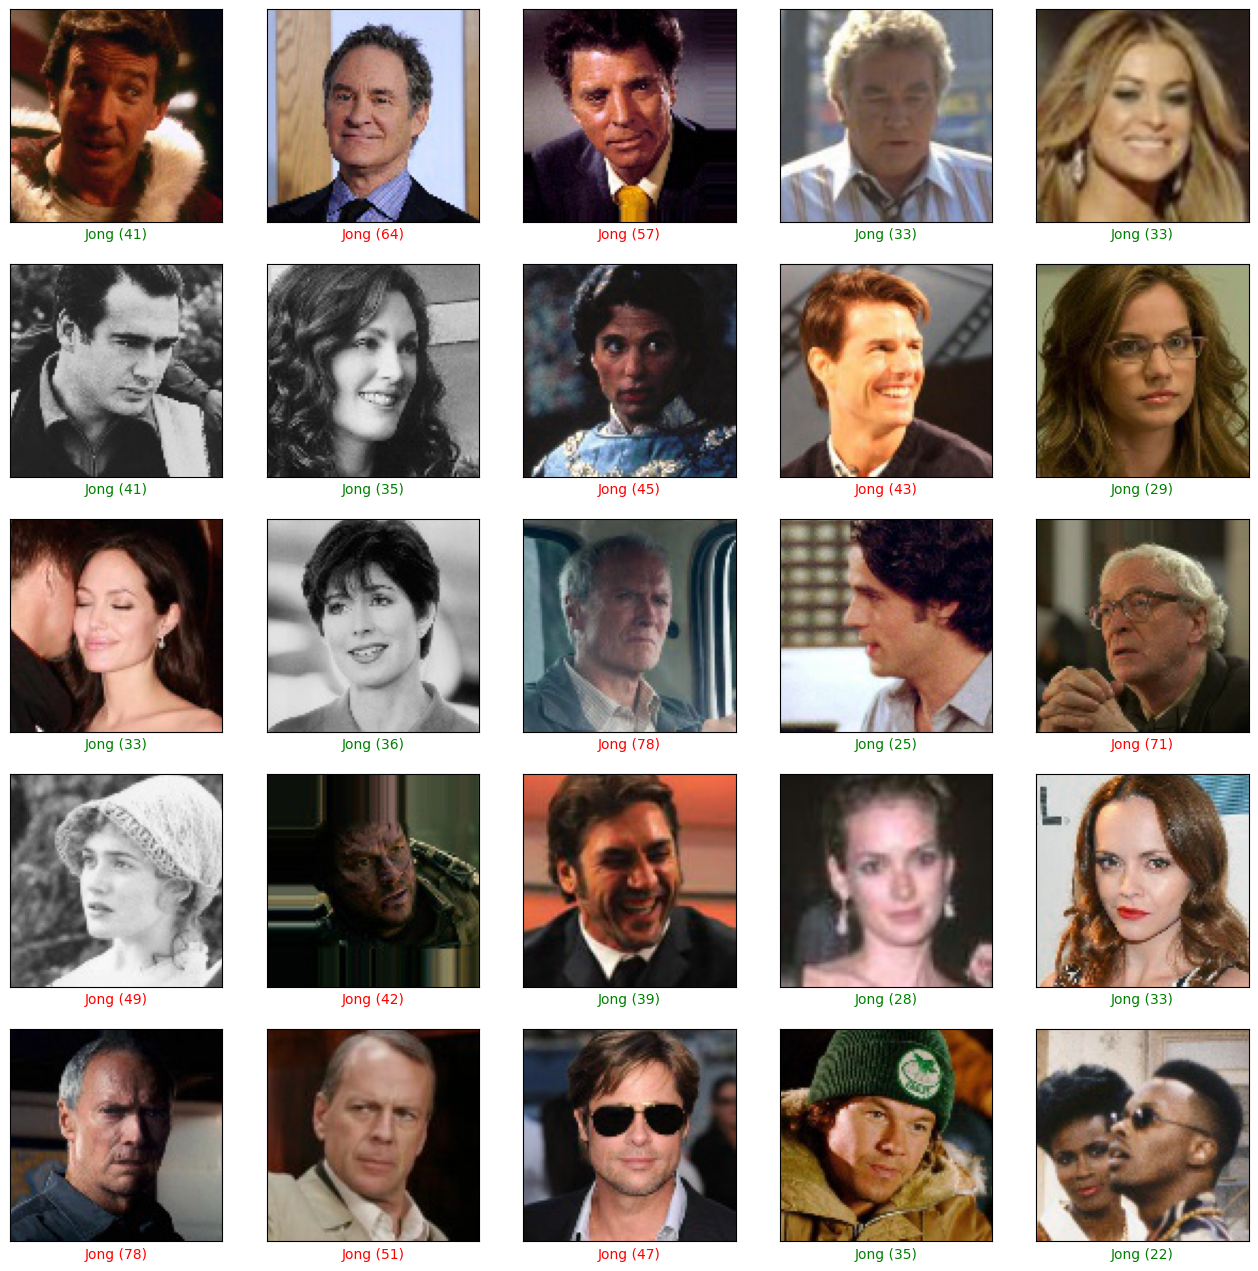

In [50]:
predict = model.predict(test_images[0:25])

predict.shape
plt.figure(figsize = (16, 16))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i])

    prediction = round(predict[i].argmax())
    actual = round(test_ages[i])

    label = "Oud" if prediction == 1 else "Jong"
    label += f' ({df_filtered.iloc[test_indices[i]]["age_on_photo"]})'

    ax.xaxis.label.set_color('green' if prediction == actual else 'red')

    plt.xlabel(label)
plt.show()

#### 5.4. Eigen data
Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)

In [51]:
def schat(pad_naar_afbeelding: str) -> str:
    img = np.array([readImage('tristan.jpg')])
    predict = model.predict([img], verbose=0)
    predict = predict[0].argmax()
    return "oud" if predict == 1 else "jong"

print(f"Ik ben {schat('tristan.jpg')}")
print(f"Natalie is {schat('natalie.jpg')}")
print(f"Mama is {schat('moeder.jpg')}")

Ik ben jong
Natalie is jong
Mama is jong


#### 5.5. Check genderbias 
Hieronder check blijkt dat er een duidelijke genderbias is in de dataset. Dit is wel grappig, want mensen zijn vaak geneigd om vrouwen jonger te schatten dan mannen ([bron](https://www.nature.com/articles/s41598-022-27009-w)).

In [52]:
predict = model.predict(test_images)

women_correct = 0
women_incorrect = 0
men_correct = 0
men_incorrect = 0

for i in range(len(predict)):
    prediction = round(predict[i].argmax())
    actual = round(test_ages[i])

    if df.iloc[test_indices[i]]["gender"] == 1:
        if men_correct + men_incorrect > len(predict) / 3:
            continue
        if prediction == actual:
            men_correct += 1
        else:
            men_incorrect += 1
    else:
        if women_correct + women_incorrect > len(predict) / 3:
            continue
        if prediction == actual:
            women_correct += 1
        else:
            women_incorrect += 1

fig = plt.figure(figsize = (10, 5))
plt.bar(["man-goed", "man-fout", "vrouw-goed", "vrouw-fout"],
        [men_correct, men_incorrect, women_correct, women_incorrect],
        color ='maroon',
        width = 0.4)

plt.title("Verdeling tussen gender")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


NameError: name 'df' is not defined

### 6. Conclusie
#### 6.1. Effectiviteit
Als je kijkt naar observeringen hierboven, zie je dat de keren dat het AI-model het fout heeft, het probleem zit in de binairheid van het model. Mensen die hij verkeerd schat, zitten meestal dicht rond de grens van 42-jaar.

Ook als ik kijk naar mijn eigen corpus, zie ik dat het model het vaak wel goed heeft. 

#### 6.2. Opvallendheden
![Img](imdb_crop/93/nm0000093_rm3278212608_1963-12-18_2009.jpg)

Bij het inspecteren van de resultaten, kwam ik een heel vreemd resultaat in. Het model schatte de bovenstaande foto als `jong` in, maar het is volgens de trainingsdata `oud`. Nu ben ik het helemaal eens met het model, maar waarom zat dit erin? Het blijkt dus dat dit een foto is van Brad Pitt uit de film [The Curious Case of Benjamin Button](https://www.imdb.com/title/tt0421715/), wat best een grappige uitkomst is!